In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
# Download the data set from github

# Install unrar to extract .rar files
!sudo apt-get install unrar -y

# Create a directory
!mkdir -p /content/dataset

# Download and extract files
dataset_urls = [
    "https://github.com/yaseen21khan/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/raw/master/AS_New_3주기.rar",
    "https://github.com/yaseen21khan/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/raw/master/MR_New_3주기.rar",
    "https://github.com/yaseen21khan/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/raw/master/MS_New_3주기.rar",
    "https://github.com/yaseen21khan/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/raw/master/MVP_New_3주기.rar",
    "https://github.com/yaseen21khan/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/raw/master/N_New_3주기.rar"
]

for url in dataset_urls:
    filename = url.split("/")[-1]           # Take the file names from the URLs
    !wget "{url}" -O "/content/{filename}"  # Download file

    !unrar x "/content/{filename}" "/content/dataset/"  # Extract the files

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
--2025-02-11 11:44:57--  https://github.com/yaseen21khan/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/raw/master/AS_New_3%EC%A3%BC%EA%B8%B0.rar
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yaseen21khan/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/master/AS_New_3%EC%A3%BC%EA%B8%B0.rar [following]
--2025-02-11 11:44:58--  https://raw.githubusercontent.com/yaseen21khan/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/master/AS_New_3%EC%A3%BC%EA%B8%B0.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, 

In [3]:
labels_path = "/content/dataset"

# Load the dataset as a tensorflow audio dataset
train_dataset, val_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory = labels_path,
    batch_size = 64,                  # samples per batch
    validation_split = 0.2,           # 20% of data for validation
    seed = 0,
    output_sequence_length = 80000,   # truncate to 80000
    subset = "both"                   # split the data into train and validation
)

# Change the label names for the dataset
train_dataset.class_names = [
    "Aortic Stenosis (AS)",
    "Mitral Regurgitation (MR)",
    "Mitral Stenosis (MS)",
    "Mitral Valve Prolapse (MVP)",
    "Normal (N)"
]

labels_names = np.array(train_dataset.class_names)
print(labels_names)

Found 1000 files belonging to 5 classes.
Using 800 files for training.
Using 200 files for validation.
['Aortic Stenosis (AS)' 'Mitral Regurgitation (MR)' 'Mitral Stenosis (MS)'
 'Mitral Valve Prolapse (MVP)' 'Normal (N)']


In [4]:
# Function to remove extra dimensions
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_dataset = train_dataset.map(squeeze, tf.data.AUTOTUNE)
val_dataset = val_dataset.map(squeeze)

In [5]:
# Data augmentation

# Randomly adjusts volume
def random_gain(audio, labels):
    gain_factor = tf.random.uniform([], 0.5, 1.5)  # Random gain factor between 0.5 (reduce) and 1.5 (increase)
    audio = audio * gain_factor
    return audio, labels

# Adds random white background noise
def white_noise(audio, labels):
    noise_level = tf.random.uniform([], 0.0, 0.2) # Random noise level
    noise = tf.random.normal(shape=tf.shape(audio), mean=0.0, stddev=noise_level) # Mean 0
    audio = audio + noise
    return audio, labels

# shifts the audio forward / backward
def time_shift(audio, labels):
    shift = tf.random.uniform([], -1600, 1600, dtype=tf.int32)  # Random shift value range [-1600, 1600]
    audio = tf.roll(audio, shift=shift, axis=0) # Shift audio forward or backward
    return audio, labels

aug_train_dataset = train_dataset.map(random_gain).map(white_noise).map(time_shift)
aug_train_dataset = train_dataset.concatenate(aug_train_dataset)

# Split validation dataset into test and validation
test_dataset = val_dataset.shard(num_shards=2, index=0)
val_dataset = val_dataset.shard(num_shards=2, index=1)

In [6]:
for audio, label in train_dataset.take(1):
  print('Original Audio Shape: ', audio.shape)
  print('Label: ', label)

Original Audio Shape:  (64, 80000)
Label:  tf.Tensor(
[1 2 2 2 2 2 1 2 2 2 0 2 0 4 4 0 2 1 3 4 2 1 2 2 1 4 3 1 3 3 1 3 4 4 3 4 3
 1 0 3 3 4 0 1 2 2 3 1 1 3 3 2 0 4 4 1 3 2 3 2 1 1 4 4], shape=(64,), dtype=int32)


In [7]:
for audio, label in train_dataset.take(1):
    spectogram = tf.signal.stft(audio, frame_length=256, frame_step=128) #STFT window processes 256 audio samples, and each moves fwd by 128 samples
    spectogram = tf.abs(spectogram) # Convert STFT output to absolute values
    spectogram = spectogram[..., tf.newaxis] # Adds a new dimension in the last position of the Spectrogram
    print(spectogram.shape)

(64, 624, 129, 1)


In [8]:
# Converts audio into spectrogram
def get_spec(audio):
    spectogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]
    return spectogram

# Applies the spectrogram transformation
def make_spec_ds(dataset):
    return dataset.map(lambda audio, label: (get_spec(audio), label), num_parallel_calls = tf.data.AUTOTUNE)

In [9]:
# Convert the datasets to spectrogram
train_spectrogram_dataset = make_spec_ds(aug_train_dataset)
test_spectrogram_dataset = make_spec_ds(test_dataset)
val_spectrogram_dataset = make_spec_ds(val_dataset)

In [10]:
# Optimizing the datasets for training
train_spectrogram_dataset = train_spectrogram_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_spectrogram_dataset = test_spectrogram_dataset.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_dataset = val_spectrogram_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [11]:
# Takes a single sample in sample_spec
for sample_spectrogram, sample_labels in train_spectrogram_dataset.take(1):
    break

In [12]:
# CNN architecture
input_shape = sample_spectrogram.shape[1:] # Extracts spectrogram dimensions
num_labels = len(labels_names)

# Normalization layer
norm_layer = layers.Normalization() # Applies normalization layer to improve convergence
norm_layer.adapt(data = train_spectrogram_dataset.map(map_func=lambda spectrogram, label: spectrogram)) # Counts the mean and variance

# CNN Model
model = models.Sequential([
    layers.Input(shape=input_shape),  # Takes in the spectrogram input
    layers.Resizing(32, 32),          # Ensure that all spectrograms have the same size 32 x 32

    norm_layer,                       # Normalize the spectrogram
    layers.Conv2D(32, 3, activation='relu'), # 1st convolution: 32 filters, 3x3 kernel
    layers.Conv2D(64, 3, activation='relu'), # 2nd convolution: 64 filters, 3x3 kernel
    layers.MaxPooling2D(), # Keeps only the important features
    layers.Dropout(0.25), # Drops 25% neurons to prevent overfitting

    # Flatten -> fully connected layer -> output layer
    layers.Flatten(), # converts 2D feature map to 1D vector
    layers.Dense(128, activation='relu'), # Fully connected layer 128 neurons
    layers.Dropout(0.5), # Drops 50% neurons
    layers.Dense(num_labels) # Output layer
])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,224 (6.20 MB)

 Trainable params: 1,625,221 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [14]:
# Compiling model
model.compile(
    metrics=['accuracy'],
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 0.0005)
)

In [15]:
# Training model
history = model.fit(
    train_spectrogram_dataset,
    validation_data = val_spectrogram_dataset,
    epochs = 10,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.2372 - loss: 1.7021 - val_accuracy: 0.6528 - val_loss: 1.4721
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - accuracy: 0.3454 - loss: 1.5387 - val_accuracy: 0.6389 - val_loss: 1.2765
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.4217 - loss: 1.4368 - val_accuracy: 0.7083 - val_loss: 1.0680
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.3859 - loss: 1.4550 - val_accuracy: 0.7917 - val_loss: 0.9604
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.4712 - loss: 1.3347 - val_accuracy: 0.8333 - val_loss: 0.8115
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.4319 - loss: 1.3539 - val_accuracy: 0.8194 - val_loss: 0.7128
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.4250 - loss: 1.4305 - val_accuracy: 0.8472 - val_loss: 0.6551
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.4999 - loss: 1.2213 - val_accuracy:

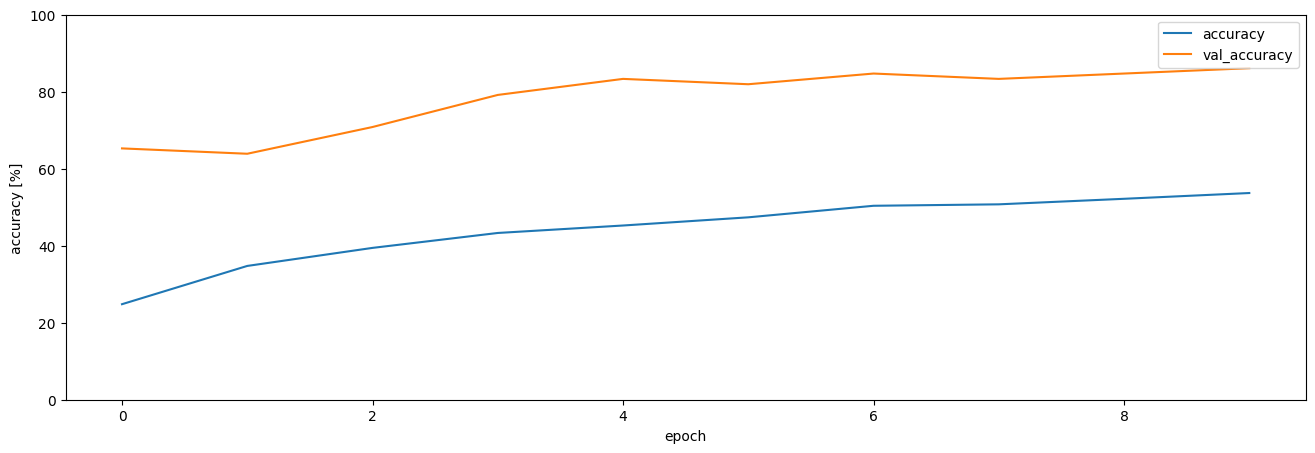

In [16]:
# Plot training history
metrics = history.history
plt.figure(figsize = (16,5))
plt.plot(history.epoch, 100* np.array(metrics['accuracy']), 100* np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0,100])
plt.xlabel("epoch")
plt.ylabel("accuracy [%]")
plt.show()

In [17]:
# Get model prediction
y_pred = model.predict(test_spectrogram_dataset)
y_pred = tf.argmax(y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [18]:
# Predictions
def convert_to_labels(labels):
        return [labels_names[label.numpy()] for label in labels]

y_pred = convert_to_labels(y_pred)
y_true = tf.concat([label for _, label in test_spectrogram_dataset], axis=0)
y_true = convert_to_labels(y_true)

correct = 0
incorrect = 0
total = len(y_true)

for idx, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
    if true_label == pred_label:
        correct += 1
    else:
        incorrect += 1
    print(f"Data {idx} : Original label: {true_label}, Prediction: {pred_label}")

correct_percentage = (correct / total) * 100
incorrect_percentage = (incorrect / total) * 100

print(f"Correct predictions: {correct} ({correct_percentage:.2f}%)")
print(f"Incorrect predictions: {incorrect} ({incorrect_percentage:.2f}%)")

Data 0 : Original label: Aortic Stenosis (AS), Prediction: Aortic Stenosis (AS)
Data 1 : Original label: Mitral Stenosis (MS), Prediction: Mitral Stenosis (MS)
Data 2 : Original label: Mitral Valve Prolapse (MVP), Prediction: Mitral Valve Prolapse (MVP)
Data 3 : Original label: Mitral Valve Prolapse (MVP), Prediction: Mitral Valve Prolapse (MVP)
Data 4 : Original label: Mitral Stenosis (MS), Prediction: Mitral Stenosis (MS)
Data 5 : Original label: Mitral Stenosis (MS), Prediction: Mitral Stenosis (MS)
Data 6 : Original label: Aortic Stenosis (AS), Prediction: Aortic Stenosis (AS)
Data 7 : Original label: Mitral Valve Prolapse (MVP), Prediction: Mitral Valve Prolapse (MVP)
Data 8 : Original label: Mitral Regurgitation (MR), Prediction: Mitral Regurgitation (MR)
Data 9 : Original label: Normal (N), Prediction: Normal (N)
Data 10 : Original label: Mitral Regurgitation (MR), Prediction: Mitral Regurgitation (MR)
Data 11 : Original label: Normal (N), Prediction: Normal (N)
Data 12 : Origin

In [19]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = np.mean(y_true == y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 81.25%
